In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
LR = 0.0001
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

i = 0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Kaggle/COVID-19_Radiography_Dataset/COVID'):
    for filename in filenames:

        if (filename[-3:] == 'png'):
          if (i < 300):
            imagePaths.append(os.path.join(dirname, filename))
            i +=1

i = 0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Kaggle/COVID-19_Radiography_Dataset/Normal'):
    for filename in filenames:

        if (filename[-3:] == 'png'):
          if (i < 300):
            imagePaths.append(os.path.join(dirname, filename))
            i +=1
            

i = 0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Kaggle/COVID-19_Radiography_Dataset/Viral Pneumonia'):
    for filename in filenames:

        if (filename[-3:] == 'png'):
          if (i < 300):
            imagePaths.append(os.path.join(dirname, filename))
            i +=1

i=0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Kaggle/LUNA_data/train/Normal'):
    for filename in filenames:
      if (filename[-3:] == 'jpg'):
        if (i < 300):
            imagePaths.append(os.path.join(dirname, filename))
            i +=1

i=0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Kaggle/LUNA_data/train/Cancer'):
    for filename in filenames:
      if (filename[-3:] == 'jpg'):
        if (i < 300):
            imagePaths.append(os.path.join(dirname, filename))
            i +=1
       



#Should return length for our dataset.

len(imagePaths)  

1500

/content/drive/MyDrive/Colab Notebooks/Kaggle/LUNA_data/train/Non_Cancer/image_497549.jpg
(512, 512, 3)


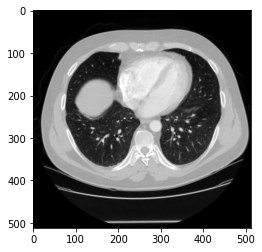

In [ ]:
i = 1000
print(imagePaths[i])

image = cv2.imread(imagePaths[i])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []


for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(1500, 224, 224, 3) (1500,)


In [ ]:
y

array(['COVID', 'COVID', 'COVID', ..., 'Cancer', 'Cancer', 'Cancer'],
      dtype='<U15')

  Labels
0  COVID
1  COVID
2  COVID
3  COVID
4  COVID 

Normal             600
Viral Pneumonia    300
COVID              300
Cancer             300
Name: Labels, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


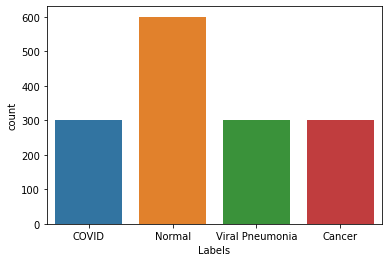

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]] 

[1. 0. 0. 0.] 

<class 'numpy.ndarray'> 

['COVID' 'Cancer' 'Normal' 'Viral Pneumonia'] 



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15, horizontal_flip=True, vertical_flip=True)

(1200, 224, 224, 3)
(1200, 4)
(300, 224, 224, 3)
(300, 4)


In [ ]:
from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf

base_model1 = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg')
features1 = base_model1.output
######################################################################################################

conv=tf.keras.layers.concatenate([features1]) #Concatenate the extracted features
####################################################################################################

conv = Sequential()
#onv.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3))(concatenated))
conv.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
conv.add(MaxPooling2D((2, 2), padding='same'))
conv.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(MaxPooling2D((2, 2), padding='same'))
conv.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(MaxPooling2D((2, 2), padding='same'))
conv.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(MaxPooling2D((2, 2), padding='same'))
conv.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(MaxPooling2D((2, 2), padding='same'))

conv.add(Flatten())
conv.add(Dropout(0.25))

conv.add(Dense(512, activation='relu'))
conv.add(Dropout(0.25))

conv.add(Dense(64, activation='relu'))

conv.add(Dense(4, activation='sigmoid'))



In [ ]:
for layer in conv.layers:
  layer.trainable = True
conv.compile(optimizer=Adam(learning_rate=LR, decay = LR/50), loss='categorical_crossentropy',metrics=['accuracy'])
#, decay = LR/EPOCHS
history = conv.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=50,
                                    verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
37/37 [==============================] - 46s 381ms/step - loss: 1.1271 - accuracy: 0.4058 - val_loss: 0.8739 - val_accuracy: 0.4567
Epoch 2/50
37/37 [==============================] - 12s 331ms/step - loss: 0.8246 - accuracy: 0.5522 - val_loss: 0.7132 - val_accuracy: 0.6133
Epoch 3/50
37/37 [==============================] - 12s 317ms/step - loss: 0.7649 - accuracy: 0.5599 - val_loss: 0.7293 - val_accuracy: 0.6067
Epoch 4/50
37/37 [==============================] - 12s 320ms/step - loss: 0.7133 - accuracy: 0.6113 - val_loss: 0.6608 - val_accuracy: 0.5633
Epoch 5/50
37/37 [==============================] - 12s 317ms/step - loss: 0.6993 - accuracy: 0.6070 - val_loss: 0.6570 - val_accuracy: 0.6167
Epoch 6/50
37/37 [==============================] - 12s 316ms/step - loss: 0.6673 - accuracy: 0.6378 - val_loss: 0.6162 - val_accuracy: 0.6967
Epoch 7/50
37/37 [==============================] - 12s 316ms/step - loss: 0.6404 - accuracy: 0.6618 - val_loss: 0.6419 - val_accuracy: 0.7000

In [ ]:
conv.save("/content/drive/MyDrive/Kaggle/Model-XCEPTION-final.h5")

In [ ]:
from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf

base_model2 = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg')
features2 = base_model2.output
######################################################################################################

#base_model3 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
#features3 = base_model3.output
conv1=tf.keras.layers.concatenate([features2]) #Concatenate the extracted features
####################################################################################################

conv1 = Sequential()
#onv.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3))(concatenated))
conv1.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
conv1.add(MaxPooling2D((2, 2), padding='same'))
conv1.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
conv1.add(MaxPooling2D((2, 2), padding='same'))
conv1.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
conv1.add(MaxPooling2D((2, 2), padding='same'))
conv1.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
conv1.add(MaxPooling2D((2, 2), padding='same'))
conv1.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
conv1.add(MaxPooling2D((2, 2), padding='same'))

conv1.add(Flatten())
conv1.add(Dropout(0.25))

conv1.add(Dense(512, activation='relu'))
conv1.add(Dropout(0.25))

conv1.add(Dense(64, activation='relu'))

conv1.add(Dense(4, activation='sigmoid'))

171458560/171446536 [==============================] - 1s 0us/step


In [ ]:
for layer in conv1.layers:
  layer.trainable = True
conv1.compile(optimizer=Adam(learning_rate=LR, decay = LR/50), loss='categorical_crossentropy',metrics=['accuracy'])
#, decay = LR/EPOCHS
history = conv1.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=60,
                                    verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
37/37 [==============================] - 13s 330ms/step - loss: 1.1497 - accuracy: 0.4033 - val_loss: 0.9107 - val_accuracy: 0.5400
Epoch 2/60
37/37 [==============================] - 12s 316ms/step - loss: 0.8957 - accuracy: 0.5291 - val_loss: 0.7610 - val_accuracy: 0.5667
Epoch 3/60
37/37 [==============================] - 12s 314ms/step - loss: 0.7737 - accuracy: 0.5788 - val_loss: 0.7818 - val_accuracy: 0.5800
Epoch 4/60
37/37 [==============================] - 12s 315ms/step - loss: 0.7412 - accuracy: 0.5882 - val_loss: 0.6775 - val_accuracy: 0.6133
Epoch 5/60
37/37 [==============================] - 12s 315ms/step - loss: 0.7237 - accuracy: 0.6036 - val_loss: 0.7308 - val_accuracy: 0.6133
Epoch 6/60
37/37 [==============================] - 12s 315ms/step - loss: 0.7047 - accuracy: 0.6113 - val_loss: 0.6890 - val_accuracy: 0.6100
Epoch 7/60
37/37 [==============================] - 12s 318ms/step - loss: 0.6735 - accuracy: 0.6267 - val_loss: 0.6326 - val_accuracy: 0.6700

In [ ]:
conv1.save("/content/drive/MyDrive/Kaggle/Model-RESNET-final.h5")
filepath= '/content/drive/MyDrive/Kaggle'

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

In [ ]:
import tensorflow as tf
def load_all_models():
    all_models = []
    model_names = ['Model-RESNET-final.h5', 'Model-XCEPTION-final.h5'] #'Model-RESNET-final.h5', 'Model-XCEPTION-final.h5'Model-3class-final.h5
    for model_name in model_names:
        filename = os.path.join('/content/drive/MyDrive/Kaggle', model_name)
        model = tf.keras.models.load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models

models = load_all_models()
for i, model in enumerate(models):
    for layer in model.layers:
        layer.trainable = False

loaded: /content/drive/MyDrive/Kaggle/Model-RESNET-final.h5
loaded: /content/drive/MyDrive/Kaggle/Model-XCEPTION-final.h5


In [ ]:
ensemble_visible = [model.input for model in models]
ensemble_outputs = [model.output for model in models]
merge = tf.keras.layers.concatenate(ensemble_outputs)
merge = tf.keras.layers.Dense(64, activation='relu')(merge)
output = tf.keras.layers.Dense(4, activation='sigmoid')(merge)
model = tf.keras.models.Model(inputs=ensemble_visible, outputs=output)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

In [ ]:
X = [X_train for _ in range(len(model.input))]
X_1 = [X_test for _ in range(len(model.input))]

In [ ]:
print(len(X_test),  '\n')
print(len(X_train))

300 

1200


In [ ]:
history = model.fit(X, y_train,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    epochs=75, 
                    validation_data=(X_1, y_test),
                    validation_steps=len(X_test) // BATCH_SIZE)

Epoch 1/75
37/37 [==============================] - 3s 74ms/step - loss: 0.4023 - accuracy: 0.8066 - val_loss: 0.5353 - val_accuracy: 0.6979
Epoch 2/75
37/37 [==============================] - 2s 52ms/step - loss: 0.4143 - accuracy: 0.8091 - val_loss: 0.5336 - val_accuracy: 0.7014
Epoch 3/75
37/37 [==============================] - 2s 52ms/step - loss: 0.3980 - accuracy: 0.8202 - val_loss: 0.5310 - val_accuracy: 0.6979
Epoch 4/75
37/37 [==============================] - 2s 52ms/step - loss: 0.4105 - accuracy: 0.8151 - val_loss: 0.5300 - val_accuracy: 0.7118
Epoch 5/75
37/37 [==============================] - 2s 53ms/step - loss: 0.3885 - accuracy: 0.8348 - val_loss: 0.5314 - val_accuracy: 0.7326
Epoch 6/75
37/37 [==============================] - 2s 52ms/step - loss: 0.3935 - accuracy: 0.8176 - val_loss: 0.5367 - val_accuracy: 0.6910
Epoch 7/75
37/37 [==============================] - 2s 53ms/step - loss: 0.4141 - accuracy: 0.7911 - val_loss: 0.5308 - val_accuracy: 0.7188
Epoch 8/75
37

### OPTUNA


In [ ]:
!pip install optuna

In [ ]:
import optuna
import tensorflow
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.integration import KerasPruningCallback
from optuna.samplers import TPESampler
from optuna.samplers import CmaEsSampler
from tensorflow.keras.backend import clear_session

base_model1 = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg')
features1 = base_model1.output
    ######################################################################################################

conv=tf.keras.layers.concatenate([features1]) #Concatenate the extracted features
    ####################################################################################################
def objective(trial):
    if tf.__version__ >= "2":
        monitor = "val_accuracy"
    else:
        monitor = "val_acc"

    tf.keras.backend.clear_session()
    epochs = trial.suggest_int('epochs', 40, 70)
    batch_size = trial.suggest_int('batch_size', 24, 32)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    dropout = trial.suggest_float("dropout_l{}".format(i), 0.5, 0.75)
    #optimiser = trial.suggest_categorical('optimizer', ['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl'])
    loss = trial.suggest_categorical('Loss', ['categorical_crossentropy','poisson','kullback_leibler_divergence']) #,'sparse_categorical_crossentropy'


    conv = Sequential()
    #onv.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3))(concatenated))
    conv.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))

    conv.add(Flatten())
    conv.add(Dropout(rate = dropout))

    conv.add(Dense(512, activation='relu'))
    conv.add(Dropout(rate = dropout))

    conv.add(Dense(64, activation='relu'))

    conv.add(Dense(5, activation='sigmoid'))

    
    #optimizer = Adam(lr=1e-3)
    conv.compile(optimizer= tensorflow.keras.optimizers.Adam(learning_rate=lr), loss = loss, metrics=['accuracy'])
    #model.fit(cancer_files_train,train_labels,batch_size=None,epochs=10)
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5),
        TFKerasPruningCallback(trial, monitor),
    ]
    history = conv.fit(X_train, 
                        y_train, 
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        callbacks=callbacks,
                        verbose=1)
    
    score = conv.evaluate(X_test, y_test, verbose=0)
    return history.history[monitor][-1]

study1 = optuna.create_study(sampler = optuna.samplers.TPESampler(), direction='maximize')
study1.optimize(objective, n_trials=5)

pruned_trials = study1.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study1.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study1.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study1.best_trial
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2021-08-24 07:38:13,402] A new study created in memory with name: no-name-e591bed6-a64e-4064-b54d-3275b2a041bd


Epoch 1/51
45/45 [==============================] - 37s 151ms/step - loss: 0.0517 - accuracy: 0.2025 - val_loss: -6.4472e-06 - val_accuracy: 0.2000
Epoch 2/51
45/45 [==============================] - 5s 117ms/step - loss: -6.4472e-06 - accuracy: 0.2000 - val_loss: -6.4472e-06 - val_accuracy: 0.2000
Epoch 3/51
45/45 [==============================] - 5s 117ms/step - loss: -6.4472e-06 - accuracy: 0.2000 - val_loss: -6.4472e-06 - val_accuracy: 0.2000
Epoch 4/51
45/45 [==============================] - 5s 117ms/step - loss: -6.4472e-06 - accuracy: 0.2000 - val_loss: -6.4472e-06 - val_accuracy: 0.2000
Epoch 5/51
45/45 [==============================] - 5s 118ms/step - loss: -6.4472e-06 - accuracy: 0.2000 - val_loss: -6.4472e-06 - val_accuracy: 0.2000
Epoch 6/51
45/45 [==============================] - 5s 117ms/step - loss: -6.4472e-06 - accuracy: 0.2000 - val_loss: -6.4472e-06 - val_accuracy: 0.2000


[I 2021-08-24 07:39:38,759] Trial 0 finished with value: 0.20000000298023224 and parameters: {'epochs': 51, 'batch_size': 27, 'lr': 0.0002131250531082458, 'dropout_l1000': 0.5303133852274494, 'Loss': 'kullback_leibler_divergence'}. Best is trial 0 with value: 0.20000000298023224.


Epoch 1/50
47/47 [==============================] - 9s 146ms/step - loss: 0.2355 - accuracy: 0.2050 - val_loss: 1.3183e-04 - val_accuracy: 0.2000
Epoch 2/50
47/47 [==============================] - 5s 117ms/step - loss: 7.1911e-04 - accuracy: 0.1892 - val_loss: 4.5134e-06 - val_accuracy: 0.2000
Epoch 3/50
47/47 [==============================] - 5s 117ms/step - loss: 2.1356e-04 - accuracy: 0.2117 - val_loss: -6.4763e-07 - val_accuracy: 0.2000
Epoch 4/50
47/47 [==============================] - 5s 117ms/step - loss: 1.3915e-04 - accuracy: 0.2158 - val_loss: -2.4960e-06 - val_accuracy: 0.2033
Epoch 5/50
47/47 [==============================] - 5s 117ms/step - loss: 1.9077e-04 - accuracy: 0.2092 - val_loss: -4.2447e-06 - val_accuracy: 0.2267
Epoch 6/50
47/47 [==============================] - 6s 122ms/step - loss: 1.0748e-04 - accuracy: 0.2000 - val_loss: -5.1487e-06 - val_accuracy: 0.2167
Epoch 7/50
47/47 [==============================] - 5s 116ms/step - loss: 5.4092e-05 - accuracy: 0.2

[I 2021-08-24 07:43:01,306] Trial 1 finished with value: 0.20000000298023224 and parameters: {'epochs': 50, 'batch_size': 26, 'lr': 3.9163929316668565e-05, 'dropout_l1000': 0.726646591372576, 'Loss': 'kullback_leibler_divergence'}. Best is trial 0 with value: 0.20000000298023224.


Epoch 1/40
42/42 [==============================] - 9s 163ms/step - loss: 0.5548 - accuracy: 0.2392 - val_loss: 0.4843 - val_accuracy: 0.3567
Epoch 2/40
42/42 [==============================] - 5s 125ms/step - loss: 0.4609 - accuracy: 0.3792 - val_loss: 0.4076 - val_accuracy: 0.4600
Epoch 3/40
42/42 [==============================] - 5s 125ms/step - loss: 0.4123 - accuracy: 0.4575 - val_loss: 0.3873 - val_accuracy: 0.5633
Epoch 4/40
42/42 [==============================] - 5s 125ms/step - loss: 0.3956 - accuracy: 0.5100 - val_loss: 0.3731 - val_accuracy: 0.5833
Epoch 5/40
42/42 [==============================] - 5s 125ms/step - loss: 0.3878 - accuracy: 0.5425 - val_loss: 0.3620 - val_accuracy: 0.6233
Epoch 6/40
42/42 [==============================] - 5s 124ms/step - loss: 0.3739 - accuracy: 0.5708 - val_loss: 0.3523 - val_accuracy: 0.6300
Epoch 7/40
42/42 [==============================] - 5s 124ms/step - loss: 0.3671 - accuracy: 0.5825 - val_loss: 0.3449 - val_accuracy: 0.6633
Epoch 

[I 2021-08-24 07:46:37,461] Trial 2 finished with value: 0.7400000095367432 and parameters: {'epochs': 40, 'batch_size': 29, 'lr': 2.1423377854508416e-05, 'dropout_l1000': 0.5250673817620851, 'Loss': 'poisson'}. Best is trial 2 with value: 0.7400000095367432.


Epoch 1/64
42/42 [==============================] - 7s 132ms/step - loss: 0.5193 - accuracy: 0.2900 - val_loss: 0.4353 - val_accuracy: 0.4933
Epoch 2/64
42/42 [==============================] - 5s 126ms/step - loss: 0.4186 - accuracy: 0.4675 - val_loss: 0.3793 - val_accuracy: 0.5100
Epoch 3/64
42/42 [==============================] - 5s 125ms/step - loss: 0.3941 - accuracy: 0.5042 - val_loss: 0.3624 - val_accuracy: 0.5767
Epoch 4/64
42/42 [==============================] - 5s 125ms/step - loss: 0.3739 - accuracy: 0.5958 - val_loss: 0.3433 - val_accuracy: 0.5933
Epoch 5/64
42/42 [==============================] - 5s 125ms/step - loss: 0.3612 - accuracy: 0.6033 - val_loss: 0.3387 - val_accuracy: 0.6233
Epoch 6/64
42/42 [==============================] - 5s 125ms/step - loss: 0.3581 - accuracy: 0.6275 - val_loss: 0.3379 - val_accuracy: 0.6300
Epoch 7/64
42/42 [==============================] - 5s 125ms/step - loss: 0.3553 - accuracy: 0.6092 - val_loss: 0.3345 - val_accuracy: 0.6300
Epoch 

[I 2021-08-24 07:50:01,747] Trial 3 finished with value: 0.7333333492279053 and parameters: {'epochs': 64, 'batch_size': 29, 'lr': 8.180236695266013e-05, 'dropout_l1000': 0.6445552942212254, 'Loss': 'poisson'}. Best is trial 2 with value: 0.7400000095367432.


Epoch 1/53
50/50 [==============================] - 8s 127ms/step - loss: 0.1179 - accuracy: 0.2158 - val_loss: -6.4472e-06 - val_accuracy: 0.2000
Epoch 2/53
50/50 [==============================] - 6s 119ms/step - loss: -3.3380e-06 - accuracy: 0.1942 - val_loss: -6.4472e-06 - val_accuracy: 0.2000
Epoch 3/53
50/50 [==============================] - 6s 118ms/step - loss: 0.0012 - accuracy: 0.1992 - val_loss: -6.4472e-06 - val_accuracy: 0.2000
Epoch 4/53
50/50 [==============================] - 6s 118ms/step - loss: 0.0026 - accuracy: 0.1950 - val_loss: -6.4472e-06 - val_accuracy: 0.2000
Epoch 5/53
50/50 [==============================] - 6s 118ms/step - loss: 1.5788e-06 - accuracy: 0.1892 - val_loss: -6.4472e-06 - val_accuracy: 0.2000
Epoch 6/53
50/50 [==============================] - 6s 119ms/step - loss: -4.7285e-06 - accuracy: 0.1967 - val_loss: -6.4472e-06 - val_accuracy: 0.2000


[I 2021-08-24 07:50:41,098] Trial 4 finished with value: 0.20000000298023224 and parameters: {'epochs': 53, 'batch_size': 24, 'lr': 0.00016430629195569302, 'dropout_l1000': 0.731489644944203, 'Loss': 'kullback_leibler_divergence'}. Best is trial 2 with value: 0.7400000095367432.


Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  0.7400000095367432
  Params: 
    epochs: 40
    batch_size: 29
    lr: 2.1423377854508416e-05
    dropout_l1000: 0.5250673817620851
    Loss: poisson


In [ ]:
!pip install pycopy-copy
!pip install cma

  Using cached pycopy-copy-3.3.3.post7.tar.gz (3.7 kB)
ERROR: File "setup.py" not found for legacy project pycopy-copy from https://files.pythonhosted.org/packages/a3/91/62fdd1a19b718f0b81f0042dd6045f90f1cf00566a49127adf75cb0fd0b3/pycopy-copy-3.3.3.post7.tar.gz#sha256=33b5c42cd8f7d57c371fcc4c137498e7f57119364c6761265c9c6e490e5761dd.


In [ ]:
import copy
import optuna
study_tpe_cmaes = copy.deepcopy(study1)
study_tpe_cmaes.sampler = optuna.integration.PyCmaSampler()
study_tpe_cmaes.optimize(objective, n_trials=5)

print("Study statistics: ")
print("  Number of finished trials: ", len(study_tpe_cmaes.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study_tpe_cmaes.best_trial
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Epoch 1/55
43/43 [==============================] - 9s 150ms/step - loss: 0.4992 - accuracy: 0.3383 - val_loss: 0.4009 - val_accuracy: 0.5467
Epoch 2/55
43/43 [==============================] - 5s 124ms/step - loss: 0.4028 - accuracy: 0.4725 - val_loss: 0.3708 - val_accuracy: 0.5633
Epoch 3/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3752 - accuracy: 0.5742 - val_loss: 0.3483 - val_accuracy: 0.6367
Epoch 4/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3600 - accuracy: 0.5933 - val_loss: 0.3428 - val_accuracy: 0.6200
Epoch 5/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3487 - accuracy: 0.6567 - val_loss: 0.3384 - val_accuracy: 0.6267
Epoch 6/55
43/43 [==============================] - 5s 123ms/step - loss: 0.3441 - accuracy: 0.6625 - val_loss: 0.3330 - val_accuracy: 0.6433
Epoch 7/55
43/43 [==============================] - 5s 123ms/step - loss: 0.3345 - accuracy: 0.6650 - val_loss: 0.3266 - val_accuracy: 0.6933
Epoch 

[I 2021-08-24 07:55:55,398] Trial 5 finished with value: 0.7233333587646484 and parameters: {'epochs': 55, 'batch_size': 28, 'lr': 9.278482448533601e-05, 'dropout_l1000': 0.6556413078431216, 'Loss': 'poisson'}. Best is trial 2 with value: 0.7400000095367432.


Epoch 1/55
43/43 [==============================] - 6s 131ms/step - loss: 0.4905 - accuracy: 0.3800 - val_loss: 0.3967 - val_accuracy: 0.5633
Epoch 2/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3973 - accuracy: 0.5225 - val_loss: 0.3592 - val_accuracy: 0.6300
Epoch 3/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3725 - accuracy: 0.5725 - val_loss: 0.3426 - val_accuracy: 0.6333
Epoch 4/55
43/43 [==============================] - 5s 123ms/step - loss: 0.3568 - accuracy: 0.6333 - val_loss: 0.3392 - val_accuracy: 0.6133
Epoch 5/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3500 - accuracy: 0.6500 - val_loss: 0.3365 - val_accuracy: 0.6700
Epoch 6/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3408 - accuracy: 0.6450 - val_loss: 0.3313 - val_accuracy: 0.6833
Epoch 7/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3365 - accuracy: 0.6700 - val_loss: 0.3212 - val_accuracy: 0.7000
Epoch 

[I 2021-08-24 07:58:19,813] Trial 6 finished with value: 0.7233333587646484 and parameters: {'epochs': 55, 'batch_size': 28, 'lr': 0.00010056631620104778, 'dropout_l1000': 0.5923342091885092, 'Loss': 'poisson'}. Best is trial 2 with value: 0.7400000095367432.


Epoch 1/55
43/43 [==============================] - 7s 138ms/step - loss: 0.5098 - accuracy: 0.2908 - val_loss: 0.4030 - val_accuracy: 0.5700
Epoch 2/55
43/43 [==============================] - 5s 125ms/step - loss: 0.4116 - accuracy: 0.4467 - val_loss: 0.3823 - val_accuracy: 0.5667
Epoch 3/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3874 - accuracy: 0.5517 - val_loss: 0.3580 - val_accuracy: 0.6333
Epoch 4/55
43/43 [==============================] - 5s 125ms/step - loss: 0.3710 - accuracy: 0.5858 - val_loss: 0.3491 - val_accuracy: 0.6300
Epoch 5/55
43/43 [==============================] - 5s 125ms/step - loss: 0.3583 - accuracy: 0.6200 - val_loss: 0.3396 - val_accuracy: 0.6333
Epoch 6/55
43/43 [==============================] - 6s 129ms/step - loss: 0.3517 - accuracy: 0.6275 - val_loss: 0.3379 - val_accuracy: 0.5967
Epoch 7/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3418 - accuracy: 0.6783 - val_loss: 0.3243 - val_accuracy: 0.6600


[I 2021-08-24 07:59:00,084] Trial 7 pruned. Trial was pruned at epoch 6.


Epoch 1/55
43/43 [==============================] - 7s 138ms/step - loss: 0.5095 - accuracy: 0.3108 - val_loss: 0.4077 - val_accuracy: 0.4133
Epoch 2/55
43/43 [==============================] - 5s 124ms/step - loss: 0.4026 - accuracy: 0.5058 - val_loss: 0.3605 - val_accuracy: 0.5733
Epoch 3/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3722 - accuracy: 0.5925 - val_loss: 0.3464 - val_accuracy: 0.6367
Epoch 4/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3604 - accuracy: 0.6067 - val_loss: 0.3399 - val_accuracy: 0.6300
Epoch 5/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3509 - accuracy: 0.6500 - val_loss: 0.3353 - val_accuracy: 0.6633
Epoch 6/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3433 - accuracy: 0.6525 - val_loss: 0.3238 - val_accuracy: 0.6767
Epoch 7/55
43/43 [==============================] - 5s 123ms/step - loss: 0.3400 - accuracy: 0.6775 - val_loss: 0.3322 - val_accuracy: 0.6367
Epoch 

[I 2021-08-24 08:02:10,244] Trial 8 finished with value: 0.7300000190734863 and parameters: {'epochs': 55, 'batch_size': 28, 'lr': 0.00010266603881411885, 'dropout_l1000': 0.6054331865203584, 'Loss': 'poisson'}. Best is trial 2 with value: 0.7400000095367432.


Epoch 1/55
43/43 [==============================] - 7s 148ms/step - loss: 0.5053 - accuracy: 0.3283 - val_loss: 0.3977 - val_accuracy: 0.4300
Epoch 2/55
43/43 [==============================] - 5s 123ms/step - loss: 0.3918 - accuracy: 0.5200 - val_loss: 0.3551 - val_accuracy: 0.6233
Epoch 3/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3634 - accuracy: 0.5858 - val_loss: 0.3488 - val_accuracy: 0.6367
Epoch 4/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3543 - accuracy: 0.6225 - val_loss: 0.3439 - val_accuracy: 0.5900
Epoch 5/55
43/43 [==============================] - 5s 124ms/step - loss: 0.3509 - accuracy: 0.5983 - val_loss: 0.3415 - val_accuracy: 0.6133
Epoch 6/55
43/43 [==============================] - 5s 123ms/step - loss: 0.3435 - accuracy: 0.6550 - val_loss: 0.3375 - val_accuracy: 0.6333
Epoch 7/55
43/43 [==============================] - 6s 130ms/step - loss: 0.3391 - accuracy: 0.6525 - val_loss: 0.3330 - val_accuracy: 0.6733
Epoch 

[I 2021-08-24 08:03:01,523] Trial 9 pruned. Trial was pruned at epoch 8.


Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  0.7400000095367432
  Params: 
    epochs: 40
    batch_size: 29
    lr: 2.1423377854508416e-05
    dropout_l1000: 0.5250673817620851
    Loss: poisson
